[PROCESSING] front → test3.png


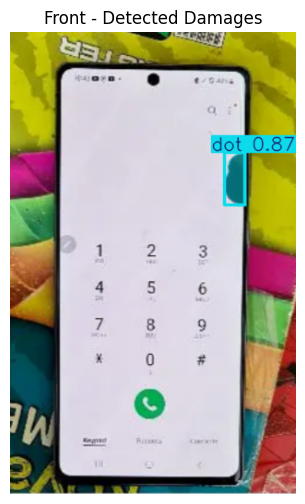

[SKIPPED] No valid image found for side: back
[SKIPPED] No valid image found for side: left
[SKIPPED] No valid image found for side: right
[SKIPPED] No valid image found for side: top
[SKIPPED] No valid image found for side: bottom

Final JSON Output:
{'damages': {'front': {'dot': [{'area_px': 1158.8}]}}}


In [12]:
import os
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from ultralytics import YOLO


# Define damage measurement type
DAMAGE_MEASUREMENT = {
    "crack": "length",
    "screen_line": "length",
    "scratch": "area",
    "dot": "area",
}

# YOLO class names (must match your trained model)
CLASS_NAMES = ["crack", "dot", "line", "scratch"]

# Sides of the phone
SIDES = ["front", "back", "left", "right", "top", "bottom"]


def process_yolo_result(result, side_name):
    """Process YOLO segmentation result for one phone side."""
    damages = {cls: [] for cls in CLASS_NAMES}

    if not result.masks:
        return {side_name: {}}

    for mask, cls_id in zip(result.masks.xy, result.boxes.cls.cpu().numpy()):
        cls_name = CLASS_NAMES[int(cls_id)]
        poly = Polygon(mask)

        if DAMAGE_MEASUREMENT.get(cls_name) == "area":
            area_px = poly.area
            damages[cls_name].append({"area_px": round(area_px, 2)})
        else:
            minx, miny, maxx, maxy = poly.bounds
            length_px = max(maxx - minx, maxy - miny)
            damages[cls_name].append({"length_px": round(length_px, 2)})

    damages = {k: v for k, v in damages.items() if v}
    return {side_name: damages}


def analyze_phone_images(model_path, side_images, show_output=True, save_output=False):
    """
    Runs YOLO segmentation on all VALID phone side images.
    Displays each result inline with Matplotlib.
    """
    model = YOLO(model_path)
    final_output = {"damages": {}}

    os.makedirs("outputs", exist_ok=True)

    for side, path in side_images.items():
        if not path or not os.path.exists(path):
            print(f"[SKIPPED] No valid image found for side: {side}")
            continue

        print(f"[PROCESSING] {side} → {path}")
        results = model.predict(path, verbose=False, save=False)
        result = results[0]

        # Plot YOLO detections
        res_img = result.plot()  # returns annotated frame
        output_path = os.path.join("outputs", f"{side}_output.jpg")

        if save_output:
            cv2.imwrite(output_path, res_img)
            print(f"[SAVED] {output_path}")

        if show_output:
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
            plt.title(f"{side.capitalize()} - Detected Damages")
            plt.axis("off")
            plt.show()

        final_output["damages"].update(process_yolo_result(result, side))

    return final_output


# Example usage
if __name__ == "__main__":
    model_path = "best2.pt"
    images = {
        "front": "test3.png",
        "back": "",
        "left": "",
        "right": "",
        "top": "",
        "bottom": ""
    }

    output = analyze_phone_images(model_path, images)
    print("\nFinal JSON Output:")
    print(output)
